In [1]:
# Copyright 2021 NVIDIA Corporation. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

In [2]:
# External dependencies
import os

import cudf  # cuDF is an implementation of Pandas-like Dataframe on GPU
import numpy as np
# import rmm

import nvtabular as nvt

from sklearn.model_selection import train_test_split

In [3]:
INPUT_DATA_DIR = os.environ.get(
    "INPUT_DATA_DIR", os.path.expanduser("./data/")
)

## Movie Feature Engineering

In [4]:
raw_movie_features = cudf.read_parquet(os.path.join(INPUT_DATA_DIR, "raw_movie_features.parquet"))
raw_movie_features.head()

,movie_id,genres,tags_unique,tags_nunique
0,3101,"[Drama, Thriller]",['Hey Dan Do You Mind Having Rabbit Stew For A...,40
1,3117,"[Drama, Romance, War]","[American Civil War, Ang Lee, Criterion, ameri...",11
2,3109,[Drama],"[70mm, CLV, Mel Gibson, Spherical Blow-Up, river]",5
3,3125,[Drama],"[BGAB LRC, Graham Greene, Julianne Moore, Neil...",20
4,3102,"[Crime, Romance, Thriller]","[Betamax, Jeff Bridges, Netflix Streaming, Nud...",18


In [5]:
movie_features_ds = nvt.Dataset(raw_movie_features)

In [6]:
cat_features = ["tags_unique", "movie_id", "genres"] >> nvt.ops.Categorify(dtype=np.int32)

In [7]:
cont_features = nvt.ColumnGroup([])
discrete_features = nvt.ColumnGroup(["tags_nunique"]) >> nvt.ops.FillMissing()

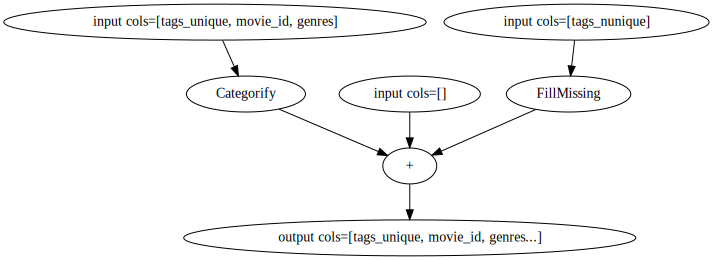

In [8]:
output = cat_features + cont_features + discrete_features
(output).graph

In [9]:
workflow = nvt.Workflow(output)

In [10]:
%%time
workflow.fit(movie_features_ds)

Failed to transform operator <nvtabular.ops.categorify.Categorify object at 0x7f502ca75970>
Traceback (most recent call last):
  File "/nvtabular/nvtabular/ops/categorify.py", line 415, in transform
    new_df[name] = new_df[name].astype(self.dtype, copy=False)
  File "/usr/local/lib/python3.8/dist-packages/cudf/core/series.py", line 3448, in astype
    raise e
  File "/usr/local/lib/python3.8/dist-packages/cudf/core/series.py", line 3440, in astype
    data = self._column.astype(dtype)
  File "/usr/local/lib/python3.8/dist-packages/cudf/core/column/column.py", line 1034, in astype
    return self.as_numerical_column(dtype)
  File "/usr/local/lib/python3.8/dist-packages/cudf/core/column/column.py", line 1106, in as_numerical_column
    raise NotImplementedError
NotImplementedError

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/nvtabular/nvtabular/workflow.py", line 358, in _transform_partition
    df = column_group.op.

RuntimeError: Failed to categorical encode column tags_unique

In [11]:
%time
movie_features = workflow.transform(movie_features_ds)

CPU times: user 1 µs, sys: 2 µs, total: 3 µs
Wall time: 3.81 µs


In [12]:
workflow.save(os.path.join(INPUT_DATA_DIR, "movie_features_workflow"))

In [13]:
movie_features.head()

Failed to transform operator <nvtabular.ops.categorify.Categorify object at 0x7f502ca75970>
Traceback (most recent call last):
  File "/nvtabular/nvtabular/ops/categorify.py", line 415, in transform
    new_df[name] = new_df[name].astype(self.dtype, copy=False)
  File "/usr/local/lib/python3.8/dist-packages/cudf/core/series.py", line 3448, in astype
    raise e
  File "/usr/local/lib/python3.8/dist-packages/cudf/core/series.py", line 3440, in astype
    data = self._column.astype(dtype)
  File "/usr/local/lib/python3.8/dist-packages/cudf/core/column/column.py", line 1034, in astype
    return self.as_numerical_column(dtype)
  File "/usr/local/lib/python3.8/dist-packages/cudf/core/column/column.py", line 1106, in as_numerical_column
    raise NotImplementedError
NotImplementedError

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/nvtabular/nvtabular/workflow.py", line 358, in _transform_partition
    df = column_group.op.

RuntimeError: Failed to categorical encode column tags_unique

In [ ]:
movie_features_df = movie_features.to_ddf().compute()

In [ ]:
import datetime

timestamp = datetime.datetime.now()
movie_features_df["datetime"] = timestamp
movie_features_df["created"] = timestamp

In [ ]:
movie_features_df

In [ ]:
movie_features_df.to_parquet(os.path.join(INPUT_DATA_DIR, "movie_features.parquet"))